In [6]:
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import tqdm
from scipy import interpolate

In [7]:
alpha = 0.4

def P_0(eta):
    return np.max([eta, 1-eta])


def Prob(n,alpha,beta):
    p0 = np.exp(-(alpha+beta)**2)
    if n==0:
        return p0
    else:
        return 1-p0
    
def Prob_Outcome(n, alpha, beta, eta):
    q=0
    for a,et in zip([alpha, -alpha], [eta, 1-eta]):
       q+= et*Prob(n,a,beta)
    return q

def Postirior(n, alpha, beta, eta):
    po = Prob(n, alpha, beta)*eta
    po /= Prob_Outcome(n, alpha, beta, eta)
    return po

def P_1(beta, eta):
    p=0
    for n in [0,1]:
        p+= Prob_Outcome(n, alpha, beta,eta)*P_0(Postirior(n, alpha, beta,eta))
    return 1-p

def P_n(beta, eta,  model, at=1):
    p=0
    for n in [0,1]:
        p+=Prob_Outcome(n, at*alpha, beta, eta)*model(Postirior(n, at*alpha, beta, eta))
    return p

In [8]:
give_lim= lambda eta,a : ((-2,2)) if eta>0.01 else ((a-1e-5, a+1e-5))

etas_min = np.linspace(1e-10,.5,100)
whole_etas = np.concatenate([etas_min, (1-etas_min)[::-1]])


L=3
PS = np.zeros((L,2*len(etas_min)))
BOPT = np.zeros((L,2*len(etas_min)))

for el in range(L)[::-1]:

    if el==L-1:

        for ind_eta, eta in enumerate(tqdm(etas_min)):
            optimization = optimize.minimize_scalar(P_1, args=(eta), method="bounded", bounds = give_lim(eta,alpha))#, bonuds= bounds=((-2,2)))#, options={"maxiter":10**9, "xatol":1e-35})
            PS[el,ind_eta]=optimization.fun
            BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]

    else:

        model = interpolate.Rbf(whole_etas, PS[el+1], smooth=0.1, epsilon=1e-12)
        
        for ind_eta, eta in enumerate(tqdm(etas_min)):
            optimization = optimize.minimize_scalar(P_n, args=(eta, model, 1/np.sqrt(L)), method="bounded", bounds = give_lim(eta,alpha))#, bonuds= bounds=((-2,2)))#, options={"maxiter":10**9, "xatol":1e-35})
            PS[el,ind_eta]=optimization.fun
            BOPT[el,ind_eta]=optimization.x
        PS[el,len(etas_min):] = PS[el,:len(etas_min)][::-1]
        BOPT[el,len(etas_min):] = -BOPT[el,:len(etas_min)][::-1]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 457.73it/s]


In [12]:
el = 1 
model = interpolate.Rbf(whole_etas, PS[el+1], smooth=0.1, epsilon=1e-12)

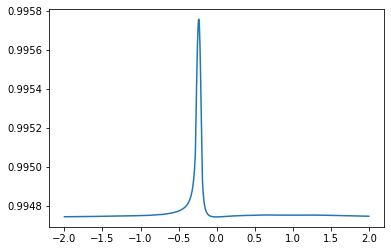

In [23]:
betas = np.linspace(-2,2,1000)
plt.plot(betas,[1-P_n(b, .99, model, 1/np.sqrt(3)) for b in betas])

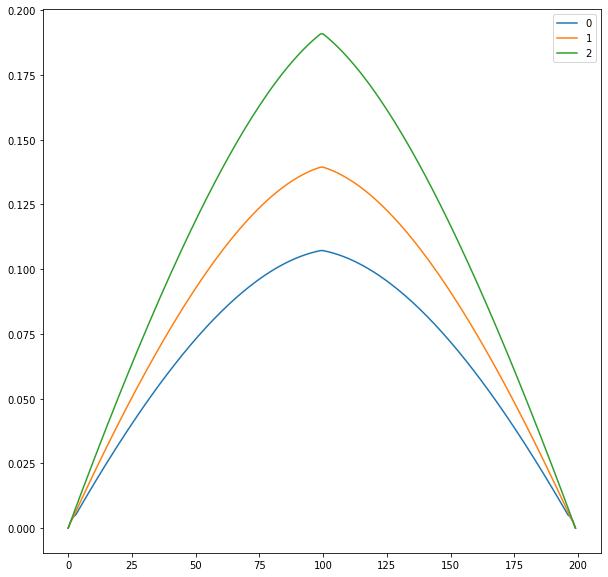

In [9]:
plt.figure(figsize=(10,10))
for k in range(len(PS)):
    plt.plot(PS[k], label=k)
plt.legend()

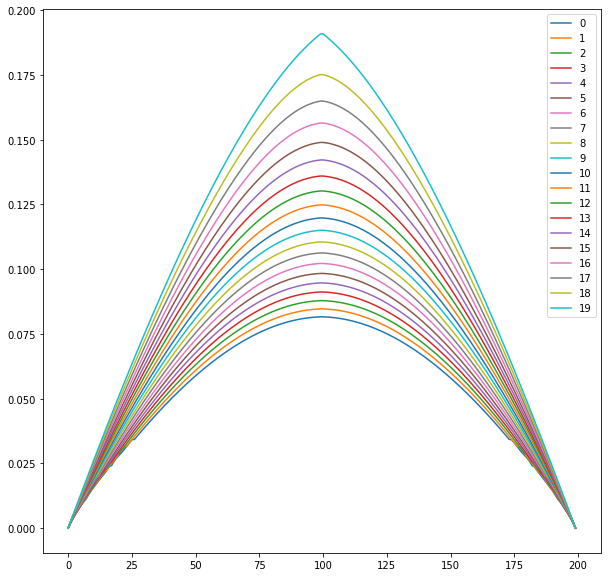

In [20]:
plt.figure(figsize=(10,10))
for k in range(len(PS)):
    plt.plot(PS[k], label=k)
plt.legend()